In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,plot_feature_distribution


In [3]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

sheet = pd.read_excel('data_input_auto/山东柴油裂解差Non-trend.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['山东柴油裂解差Non-Trend/F0.2'].last_valid_index()
sheet.columns

Index(['山东柴油裂解差Non-Trend/F0.2', '新增人民币贷款（票据，12MMA）', '水泥价格指数/华东',
       '工业企业原材料存货(剔除PPI)同比', '官方制造PMI-财新制造业PMI', '新增社融（人民币贷款）同差',
       '泛亚内贸集装箱运价指数：华东指数', 'DR007 - 7天逆回购利率/15DMA90日环差', '周度螺纹产量超季节性/4年',
       '1年期中国实际收益率', '中美10年实际利差/日度'],
      dtype='object')

In [4]:
# 获取last_day之后的数据
future_data_30days = sheet[sheet.index > last_day]
# 计算需要的31个工作日
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]


if len(future_data_30days) == 0:
    new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
    sheet = sheet.reindex(sheet.index.union(new_index))

elif future_data_30days.index.max() > target_end:
    sheet = sheet[sheet.index <= target_end]
    new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
    sheet = sheet.reindex(sheet.index.union(new_index))

else:
    max_future_date = future_data_30days.index.max() if len(future_data_30days) > 0 else last_day
    new_index = pd.date_range(start=max_future_date+ pd.DateOffset(1), end=target_end, freq='B')
    sheet = sheet.reindex(sheet.index.union(new_index))

sheet = sheet.sort_index()


fill_methods = {
    '新增人民币贷款（票据，12MMA）': 'interpolate',
    '水泥价格指数/华东': 'interpolate',
    '工业企业原材料存货(剔除PPI)同比': 'interpolate', 
    '官方制造PMI-财新制造业PMI': 'interpolate', 
    '新增社融（人民币贷款）同差': 'interpolate',
    '泛亚内贸集装箱运价指数：华东指数': 'interpolate', 
    'DR007 - 7天逆回购利率/15DMA90日环差': 'interpolate', 
    '周度螺纹产量超季节性/4年': 'interpolate',
    '1年期中国实际收益率': 'interpolate', 
    '中美10年实际利差/日度': 'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.loc[:last_day, '山东柴油裂解差Non-Trend/F0.2'] = sheet.loc[:last_day, '山东柴油裂解差Non-Trend/F0.2'].interpolate(method='linear')

sheet['新增人民币贷款（票据，12MMA）_提前30天'] = sheet['新增人民币贷款（票据，12MMA）'].shift(30)
sheet['水泥价格指数/华东_提前20天'] = sheet['水泥价格指数/华东'].shift(20)
sheet['工业企业原材料存货(剔除PPI)同比_提前30天'] = sheet['工业企业原材料存货(剔除PPI)同比'].shift(30)
sheet['官方制造PMI-财新制造业PMI_提前20天'] = sheet['官方制造PMI-财新制造业PMI'].shift(20)
sheet['新增社融（人民币贷款）同差_提前20天'] = sheet['新增社融（人民币贷款）同差'].shift(20)
sheet['泛亚内贸集装箱运价指数：华东指数_提前25天'] = sheet['泛亚内贸集装箱运价指数：华东指数'].shift(25)
sheet['DR007 - 7天逆回购利率/15DMA90日环差_提前20天'] = sheet['DR007 - 7天逆回购利率/15DMA90日环差'].shift(20)
sheet['周度螺纹产量超季节性/4年_提前20天'] = sheet['周度螺纹产量超季节性/4年'].shift(20)
sheet['1年期中国实际收益率_提前75天'] = sheet['1年期中国实际收益率'].shift(75)
sheet['中美10年实际利差/日度_提前60天'] = sheet['中美10年实际利差/日度'].shift(60)


sheet['1年期中国实际收益率_提前75天_逆序'] = reverse_column(sheet, '1年期中国实际收益率_提前75天')
sheet['中美10年实际利差/日度_逆序'] = reverse_column(sheet, '中美10年实际利差/日度')

sheet['1年期中国实际收益率_提前75天_逆序_2023-01-01之后'] = np.where(
    sheet.index >= pd.Timestamp('2023-01-01'),
    sheet['1年期中国实际收益率_提前75天_逆序'],
    np.nan
)
################################# 数据筛选  #################################
# 重置索引 确保 `Date` 为 datetime 类型
sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])
# 筛选日期大于 2024-01-01 的行
sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]
# 重置索引,使其从0开始 
sheet_daily = sheet_daily.reset_index(drop=True)
# 删除 在 last_day 之前 预测标的 为 空值的 行
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['山东柴油裂解差Non-Trend/F0.2'].notna())
]


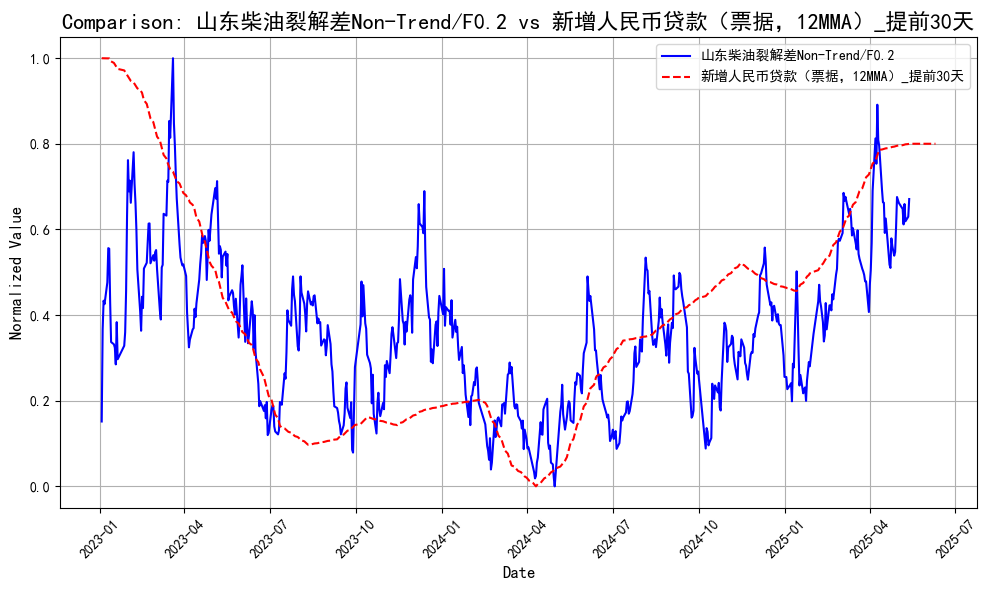

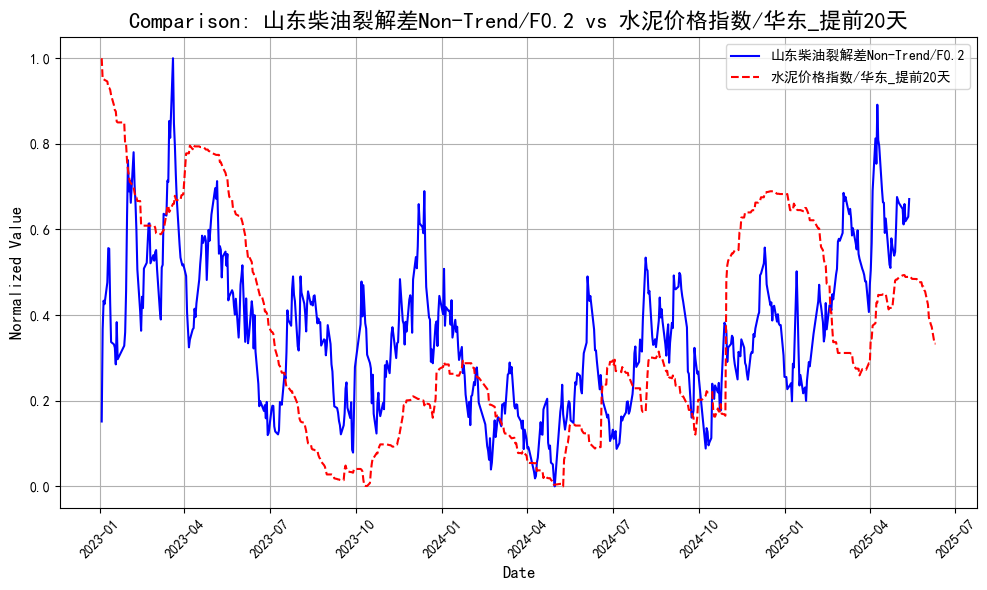

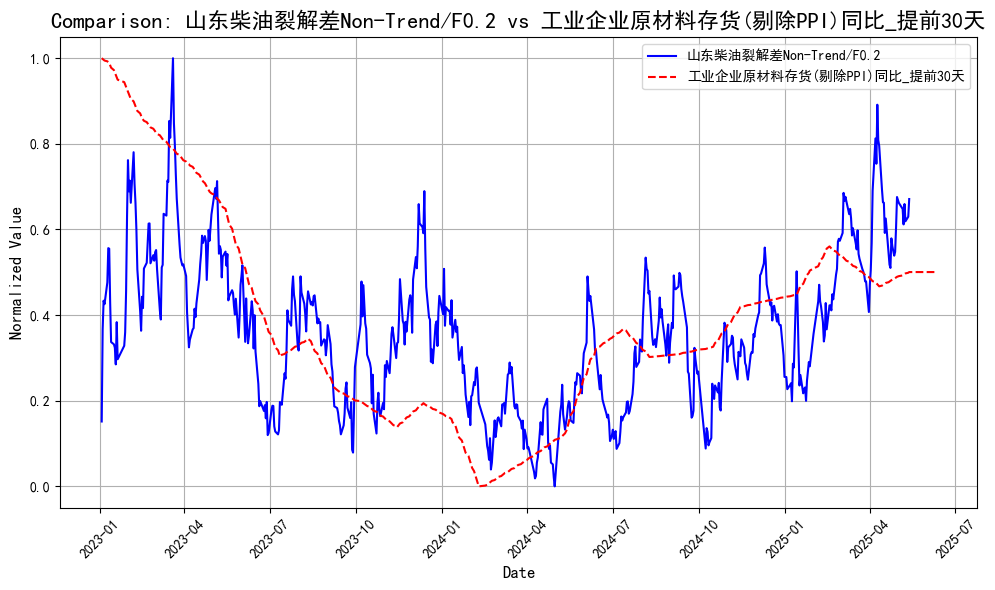

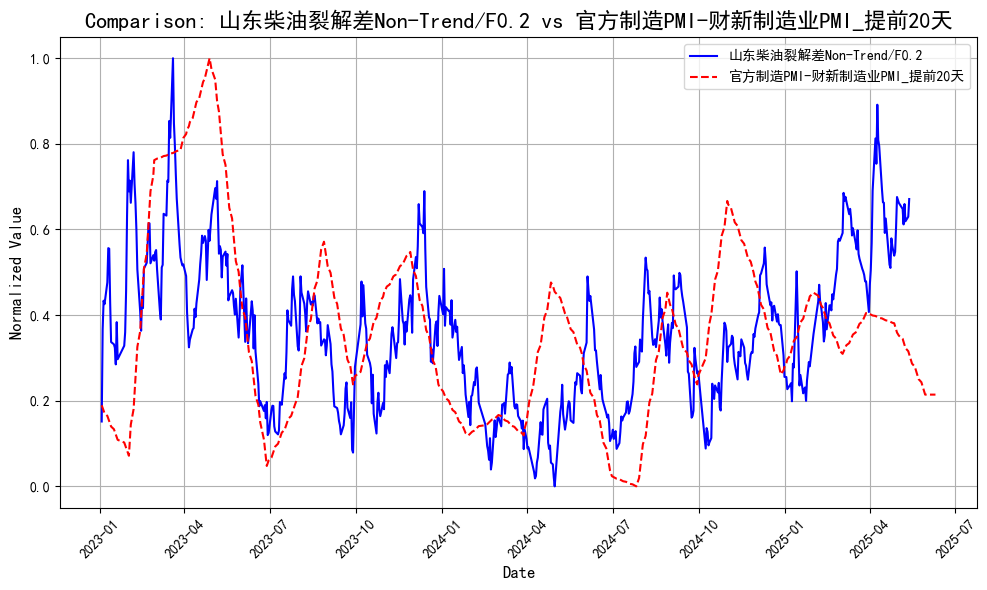

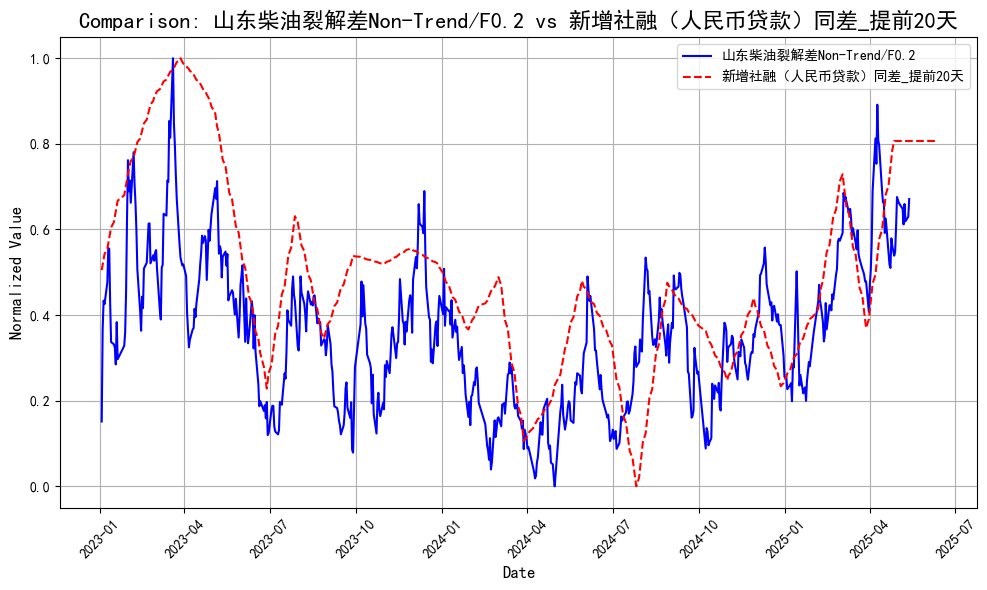

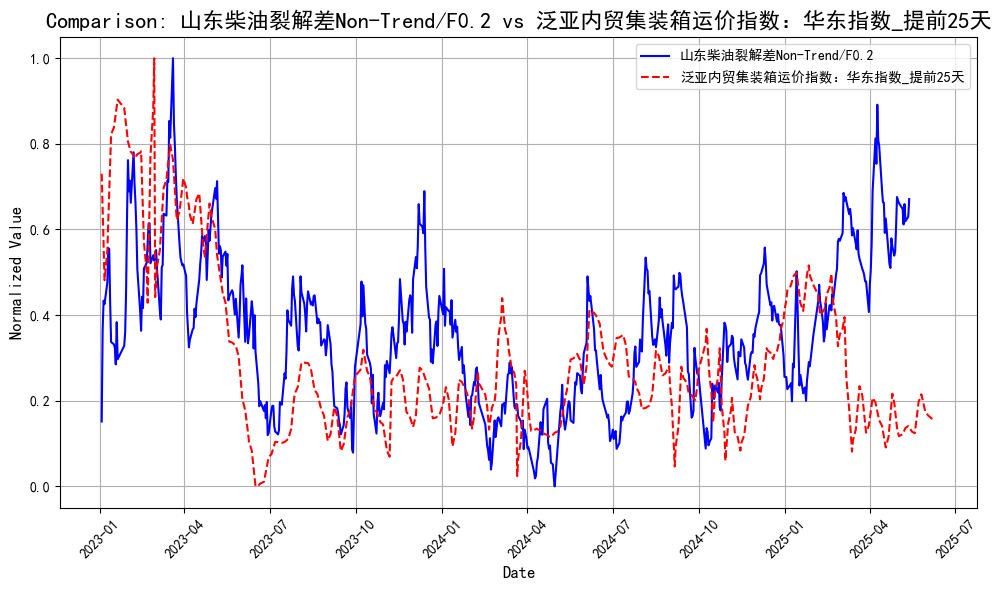

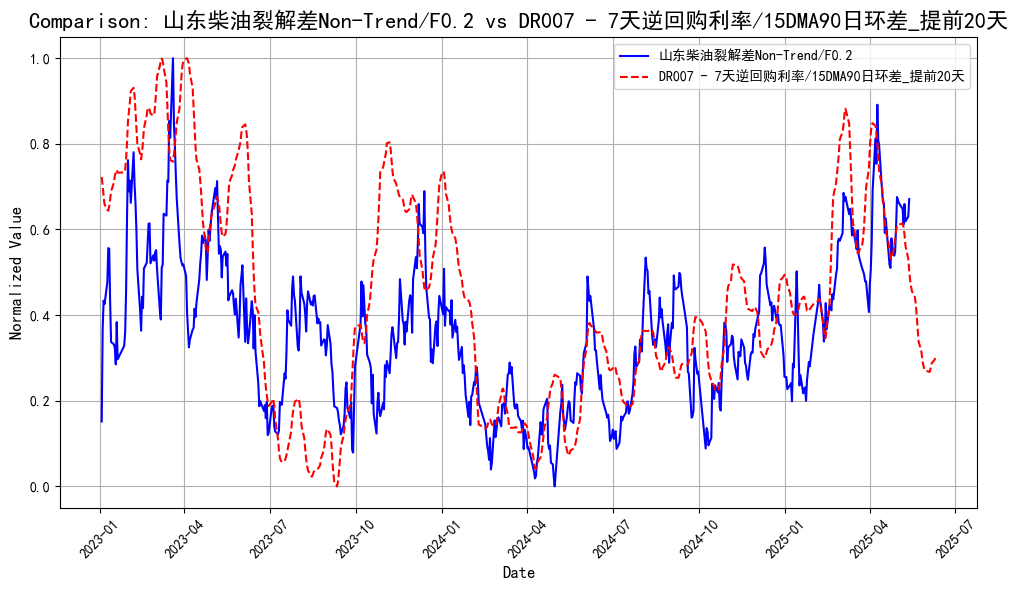

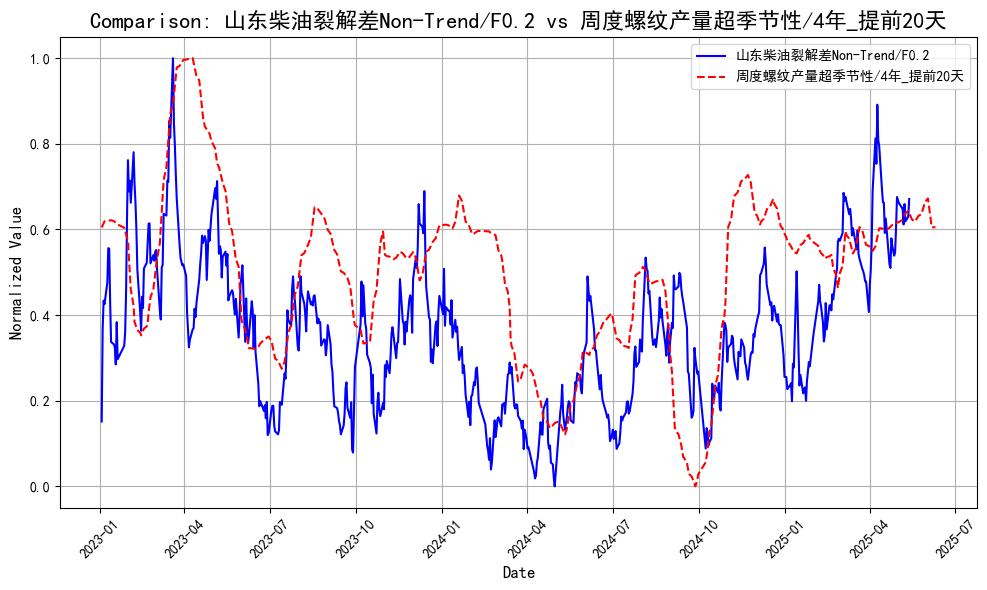

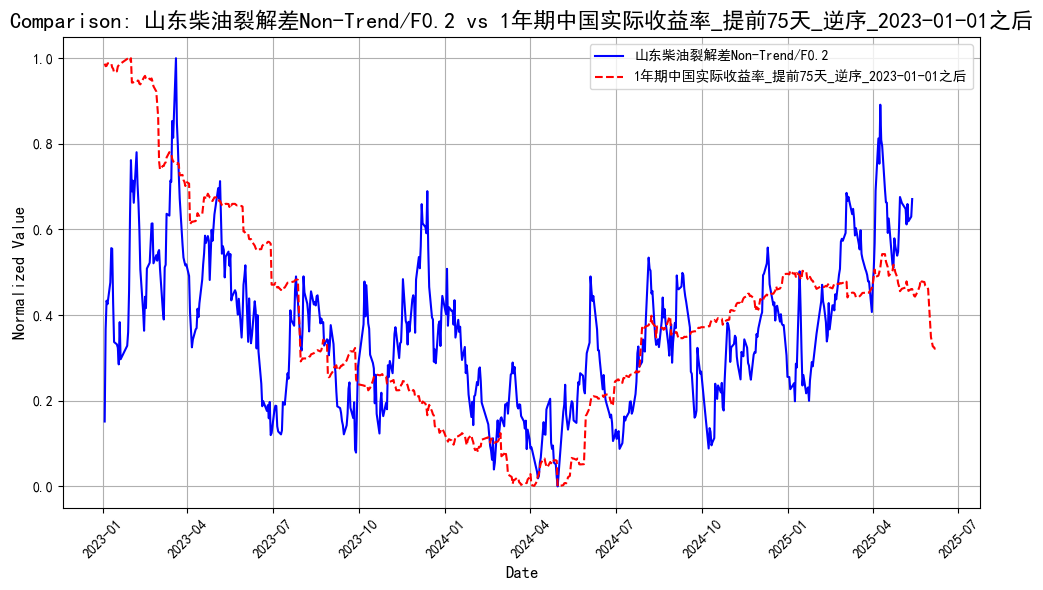

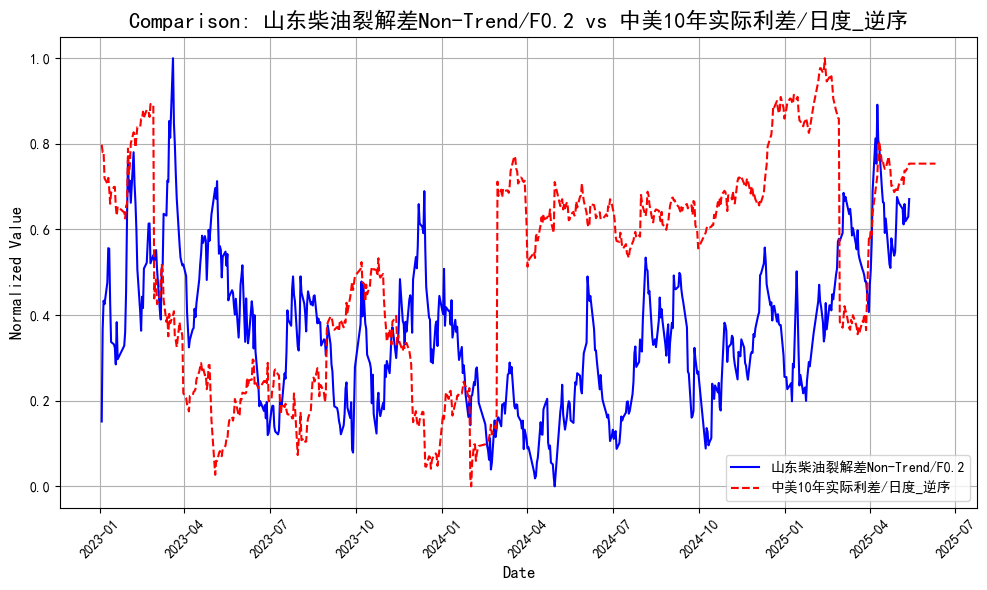

In [5]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='山东柴油裂解差Non-Trend/F0.2', 
    compare_cols=[
        '新增人民币贷款（票据，12MMA）_提前30天',
        '水泥价格指数/华东_提前20天',
        '工业企业原材料存货(剔除PPI)同比_提前30天',
        '官方制造PMI-财新制造业PMI_提前20天',
        '新增社融（人民币贷款）同差_提前20天',
        '泛亚内贸集装箱运价指数：华东指数_提前25天',
        'DR007 - 7天逆回购利率/15DMA90日环差_提前20天',
        '周度螺纹产量超季节性/4年_提前20天',
        '1年期中国实际收益率_提前75天_逆序_2023-01-01之后',
        '中美10年实际利差/日度_逆序'
        ]
)

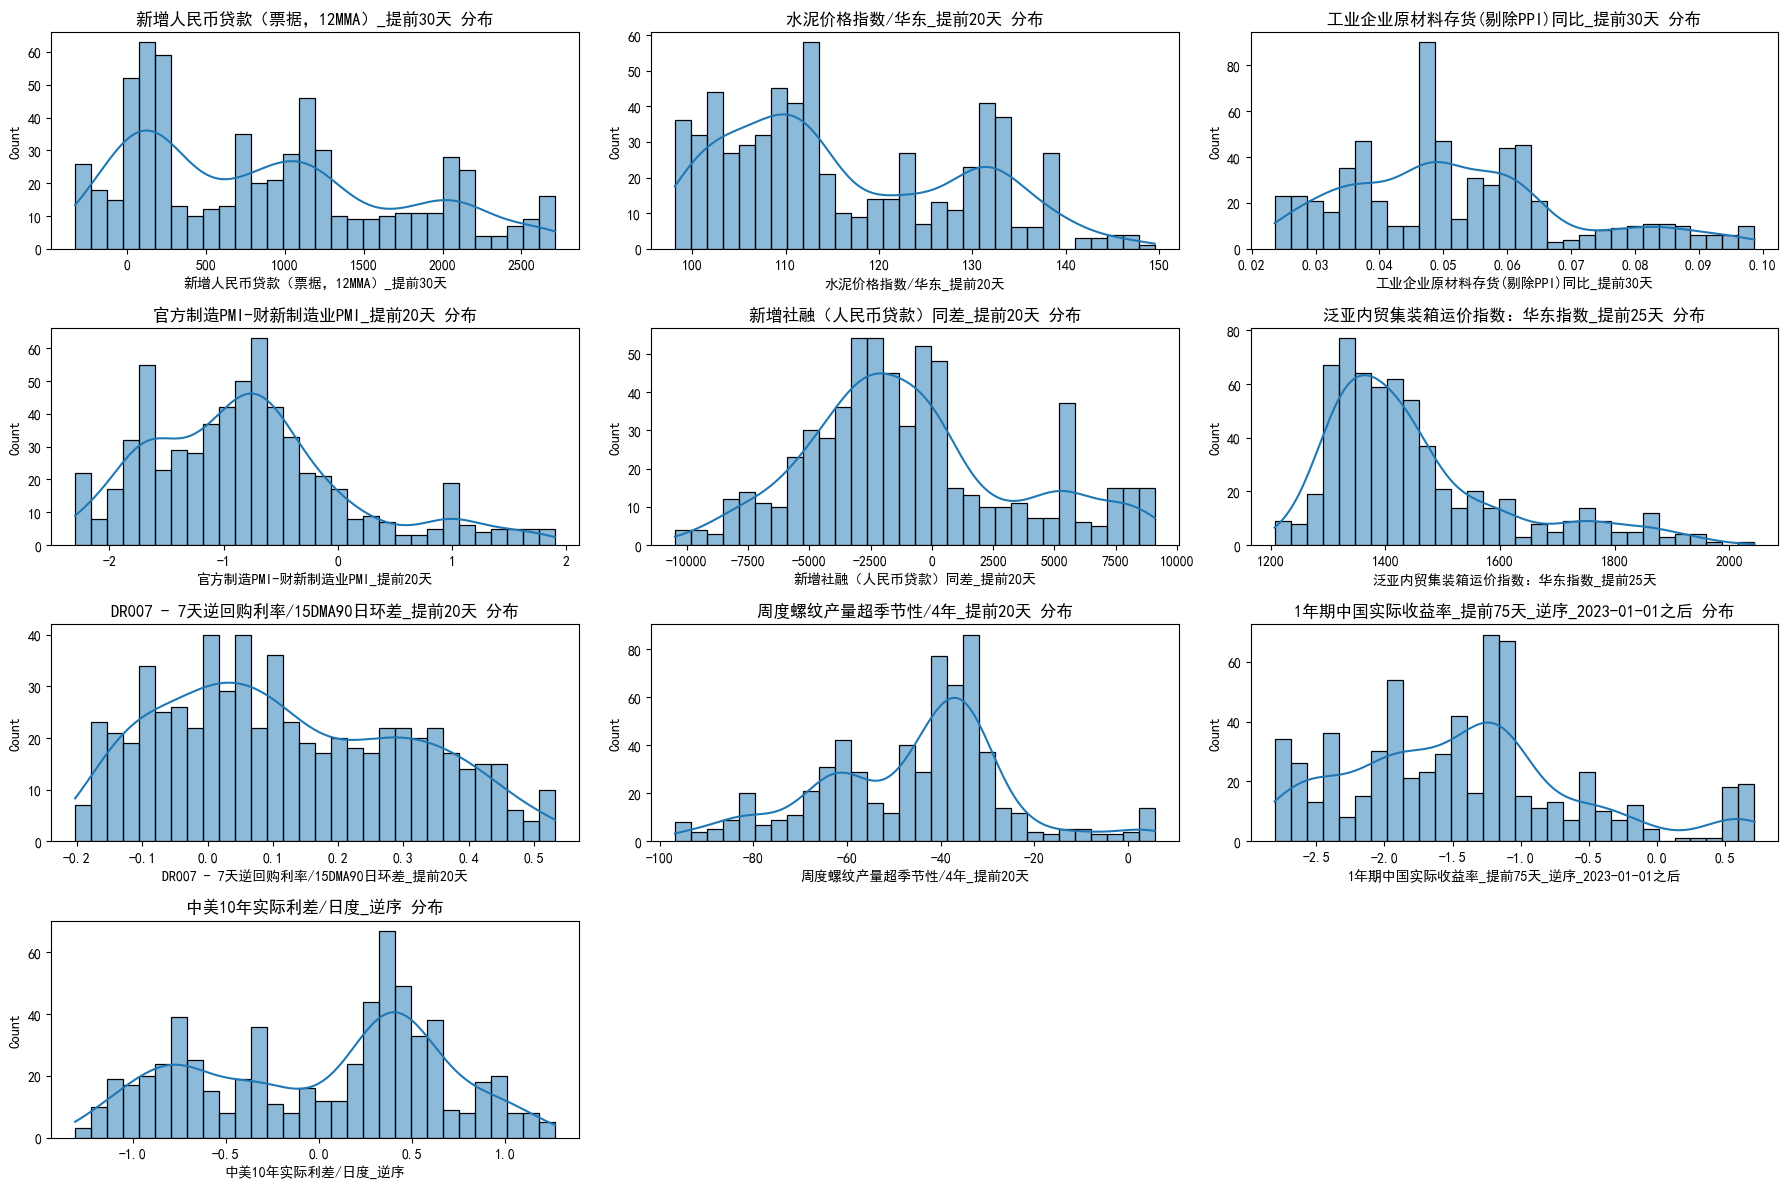

In [6]:
plot_feature_distribution(
    sheet_daily_plot,
    feature_columns=[
        '新增人民币贷款（票据，12MMA）_提前30天',
        '水泥价格指数/华东_提前20天',
        '工业企业原材料存货(剔除PPI)同比_提前30天',
        '官方制造PMI-财新制造业PMI_提前20天',
        '新增社融（人民币贷款）同差_提前20天',
        '泛亚内贸集装箱运价指数：华东指数_提前25天',
        'DR007 - 7天逆回购利率/15DMA90日环差_提前20天',
        '周度螺纹产量超季节性/4年_提前20天',
        '1年期中国实际收益率_提前75天_逆序_2023-01-01之后',
        '中美10年实际利差/日度_逆序'
       ]
)

In [7]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 100
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '新增人民币贷款（票据，12MMA）_提前30天',
        '水泥价格指数/华东_提前20天',
        '工业企业原材料存货(剔除PPI)同比_提前30天',
        '官方制造PMI-财新制造业PMI_提前20天',
        '新增社融（人民币贷款）同差_提前20天',
        '泛亚内贸集装箱运价指数：华东指数_提前25天',
        'DR007 - 7天逆回购利率/15DMA90日环差_提前20天',
        '周度螺纹产量超季节性/4年_提前20天',
        '1年期中国实际收益率_提前75天_逆序_2023-01-01之后',
        '中美10年实际利差/日度_逆序'
]

predict_column = '山东柴油裂解差Non-Trend/F0.2'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.1,  # 较小的学习率
    'max_depth': 3,  # 控制树的深度防止过拟合
    'min_child_weight': 8,  # 控制过拟合
    'subsample': 0.8,  # 随机采样防止过拟合
    'colsample_bytree': 0.8,  # 特征随机采样
    'gamma': 0.1,  # 控制分裂
    'reg_alpha': 0.1,  # L1正则化
    'reg_lambda': 1.0,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
}

num_boost_round = 500
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=50,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=100 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:275.14563	train-rmse:181.04701


[100]	eval-rmse:187.48726	train-rmse:52.86714


[200]	eval-rmse:184.40584	train-rmse:36.81943


[300]	eval-rmse:182.62727	train-rmse:29.04198


[400]	eval-rmse:181.05770	train-rmse:24.17320


[499]	eval-rmse:179.41019	train-rmse:21.03981


训练集 MSE (DMatrix): 491.3907, 训练集 R² (DMatrix): 0.9883
测试集 MSE (DMatrix): 32188.0151, 测试集 R² (DMatrix): 0.1736


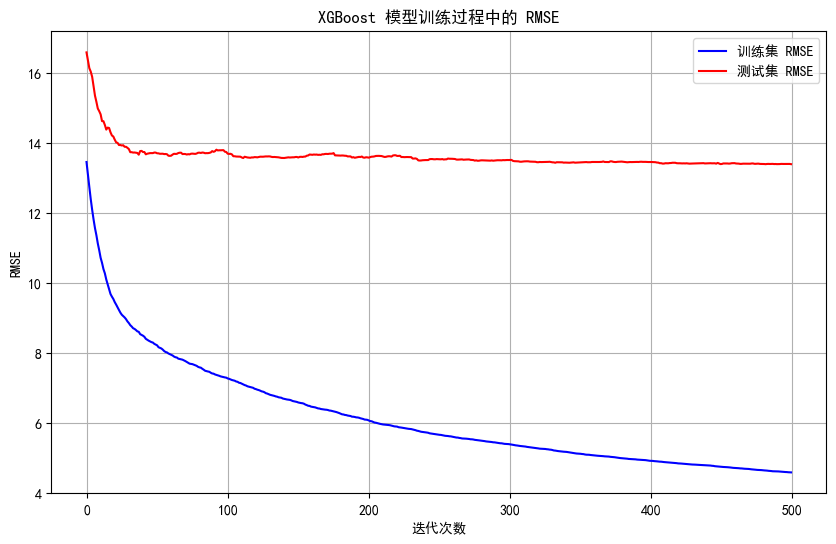

In [8]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重


# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=50,
    evals_result=evals_result,
    verbose_eval=100
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:191.32200

[100]	train-rmse:54.51477


[200]	train-rmse:39.24419

[300]	train-rmse:31.03077


[400]	train-rmse:26.60679


[499]	train-rmse:23.23307


全部数据 MSE: 593.6188, 全部数据 R²: 0.9873


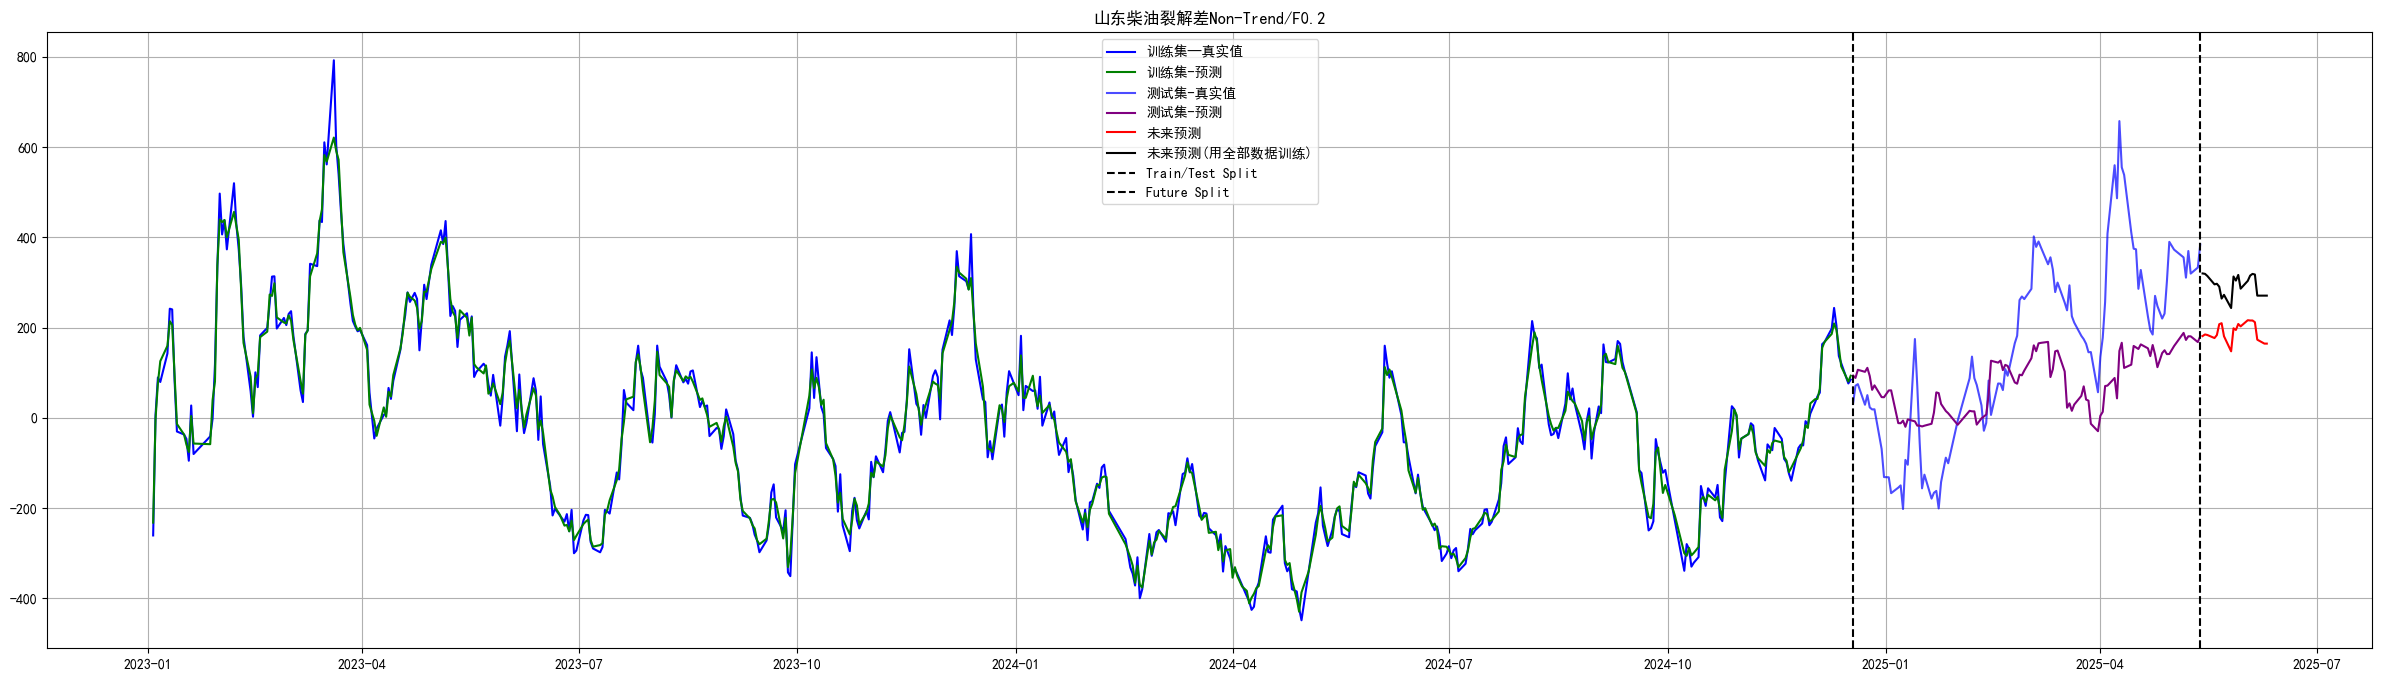

In [10]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('山东柴油裂解差Non-Trend/F0.2')
plt.legend()
plt.grid(True)
plt.show()


---

In [11]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并历史真实值和预测值
merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
# 按日期排序 倒叙
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel 在 eta 文件夹里
merged_df_daily.to_excel('eta/山东柴油裂解差Non-Trend—F0.2_合并数据.xlsx', index=False,float_format='%.4f')

############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/山东柴油裂解差Non-Trend-F0.2_月度数据.xlsx', index=False, float_format='%.4f')

In [12]:
merged_df_daily

,Date,真实值,预测值
624,2025/06/10,NaN,270.610291
623,2025/06/09,NaN,270.610291
622,2025/06/06,NaN,270.610291
621,2025/06/05,NaN,317.376862
620,2025/06/04,NaN,318.766785
...,...,...,...
4,2023/01/09,142.3451,NaN
3,2023/01/06,79.3061,NaN
2,2023/01/05,89.3519,NaN
1,2023/01/04,6.0505,NaN


In [13]:
merged_df_monthly

,Date,真实值,预测值
29,2025/06/30,NaN,295.173248
28,2025/05/31,349.133679,253.189697
27,2025/04/30,339.495520,119.241829
26,2025/03/31,263.137119,85.149620
25,2025/02/28,105.954879,65.784813
24,2025/01/31,-107.051260,6.888962
23,2024/12/31,74.912855,105.554054
22,2024/11/30,-60.811018,-60.600143
21,2024/10/31,-186.668375,-184.319305
20,2024/09/30,-4.378662,-9.171517


---

In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "山东柴油裂解差Non-Trend/F0.2"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "山东柴油裂解差Non-Trend/F0.2"
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/05/31)
数据已成功更新到Excel文件
